In [1]:
from sklearn.datasets import load_iris
from modules.stability_scheme1 import stability
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from modules.utils import clustering_algs
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

iris = load_iris()
data = iris.data[:, 1:3]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(iris.data)

In [ ]:
list_bootClustering = []
B = 5; K=3
org_data = X_pca
idx = np.arange(org_data.shape[0])
Indicator = {True: 1, False: 0}

instability_vector = np.empty((B, 1))
for b in tqdm(range(B)):
    resample_idx = np.random.choice(org_data.shape[0], size=org_data.shape[0], replace=True)
    boot_data = org_data[resample_idx, ]
    
    # clustering for the bootstrapped data
    _bootClustering_1 = clustering_algs(data = boot_data,
                                        clst_alg = 'kmeans',
                                        K = K,
                                        random_state = b)
    
    _bootClustering_2 = clustering_algs(data = boot_data,
                                        clst_alg = 'kmeans',
                                        K = K,
                                        random_state = b)
    
    list_bootClustering.append([_bootClustering_1, _bootClustering_2])

    o2b_labels_1 = cdist(_bootClustering_1.center, org_data, metric='euclidean').argmin(axis=0) # original data를 bootClustering_1의 center에 mapping
    o2b_labels_2 = cdist(_bootClustering_2.center, org_data, metric='euclidean').argmin(axis=0) # original data를 bootClustering_2의 center에 mapping
    
    temp_instability = 0
    for i in idx:
        for j in idx:
            # if o2b_labels_1[i] == o2b_labels_1[j]:
            #     if o2b_labels_2[i] != o2b_labels_2[j]:
            #         temp_instability += 1
            # elif o2b_labels_1[i] != o2b_labels_1[j]:
            #     if o2b_labels_2[i] == o2b_labels_2[j]:
            #         temp_instability += 1
            temp_instability += abs(Indicator[o2b_labels_1[i] == o2b_labels_1[j]] - Indicator[o2b_labels_2[i] == o2b_labels_2[j]])
    
    instability_vector[b] = temp_instability/(len(idx)**2)

instability = np.mean(instability_vector)
    


In [15]:
np.random.choice(10, 5, replace=True)

array([4, 7, 5, 4, 7])

In [40]:
class instability():
    @staticmethod
    def plot_K_optimization(data, max_K=9, B=5):
        instability_list = []
        for k in range(2, max_K+1):
            _instability = instability(org_data=X_pca, K=k)
            instability_list.append(_instability.instability)
        
        print(instability_list)
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        plt.plot(range(2,max_K+1), instability_list, marker='o', label="S$_{min}$");
        plt.legend()
        plt.ylabel("S$_{min}$", fontdict={'fontsize':15})
        plt.xlabel("K (number of clusters)", fontdict={'fontsize':15})
        plt.title("Optimize the K (Bootstrapping=%d times for each K)" % B)
        ax.set_xticks(range(2,max_K+1))

    @staticmethod
    def instability_path(data, K_list=None, B=5):
        N = data.shape[0] # number of whole data
        if K_list == None:
            K_list = [3,4,5,6]
        n_list = [int(N/4/4), int(N/4/3), int(N/4/2), int(N/4), int(N/3), int(N/2), N]

        instability_paths = np.empty((len(K_list), len(n_list)))
        
        for ki, k in enumerate(K_list):
            for ni, temp_n in enumerate(n_list):
                _instability = instability(org_data=data, K=k, B=B, resample_size=temp_n)
                instability_paths[ki, ni] = _instability.instability

        plt.plot(instability_paths, 'o--')
        plt.legend(K_list)
        return instability_paths


    def __init__(self, org_data, K=2, B=10, clst_alg='kmeans', resample_size=None) -> None:
        self.org_data = org_data
        self.K = K
        self.B = B
        self.clst_alg = clst_alg
        if type(resample_size) == type(None):
            self.resample_size = org_data.shape[0]
        else:
            self.resample_size = resample_size

        # Clustering for the each pair of the bootstrapped data
        list_bootClustering = []
        instability_vector = np.empty((B, 1))
        idx = np.arange(org_data.shape[0])
        Indicator = {True: 1, False: 0}
        
        for b in range(B):
            resample_idx = np.random.choice(org_data.shape[0], size=self.resample_size, replace=True)
            boot_data_1 = org_data[resample_idx, ]

            resample_idx = np.random.choice(org_data.shape[0], size=self.resample_size, replace=True)
            boot_data_2 = org_data[resample_idx, ]
            
            # clustering for the bootstrapped data
            _bootClustering_1 = clustering_algs(data = boot_data_1,
                                                clst_alg = 'kmeans',
                                                K = K,
                                                random_state = 2*b)
            
            _bootClustering_2 = clustering_algs(data = boot_data_2,
                                                clst_alg = 'kmeans',
                                                K = K,
                                                random_state = 2*b+1)
            
            list_bootClustering.append([_bootClustering_1, _bootClustering_2])

            o2b_labels_1 = cdist(_bootClustering_1.center, org_data, metric='euclidean').argmin(axis=0) # original data를 bootClustering_1의 center에 mapping
            o2b_labels_2 = cdist(_bootClustering_2.center, org_data, metric='euclidean').argmin(axis=0) # original data를 bootClustering_2의 center에 mapping
            
            temp_instability = 0
            for i in idx:
                for j in idx:
                    # if o2b_labels_1[i] == o2b_labels_1[j]:
                    #     if o2b_labels_2[i] != o2b_labels_2[j]:
                    #         temp_instability += 1
                    # elif o2b_labels_1[i] != o2b_labels_1[j]:
                    #     if o2b_labels_2[i] == o2b_labels_2[j]:
                    #         temp_instability += 1
                    temp_instability += abs(Indicator[o2b_labels_1[i] == o2b_labels_1[j]] - Indicator[o2b_labels_2[i] == o2b_labels_2[j]])
            
            instability_vector[b] = temp_instability/(len(idx)**2)
        instability = np.mean(instability_vector)

        self.list_bootClustering = list_bootClustering
        self.instability_vector = instability_vector
        self.instability = instability
        

In [10]:
instability_list = []
for k in tqdm(range(9)):
    if k < 2:
        continue
    _instability = instability(org_data=X_pca, K=k)

    instability_list.append(_instability.instability)
    print(_instability.instability)


  0%|          | 0/9 [00:00<?, ?it/s]

0.01056
0.045635555555555554
0.08537777777777777
0.08446222222222223
0.08331555555555556
0.09123555555555554
0.06154666666666666


[0.009235555555555556, 0.03219555555555555, 0.06088888888888888, 0.07636444444444444, 0.08081777777777778, 0.057057777777777784, 0.06276444444444443, 0.060044444444444435]


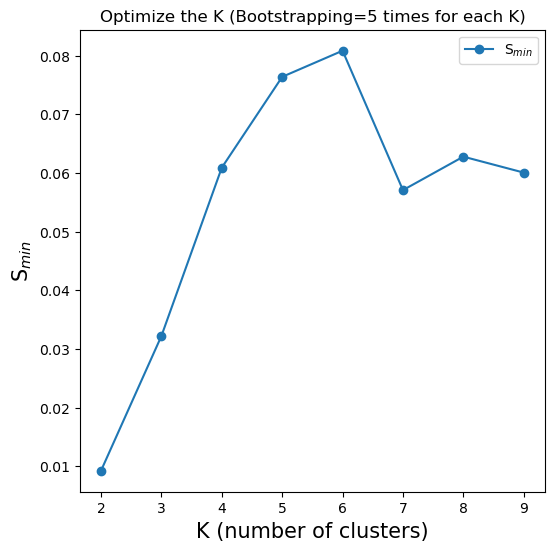

In [12]:
instability.plot_K_optimization(data=X_pca)

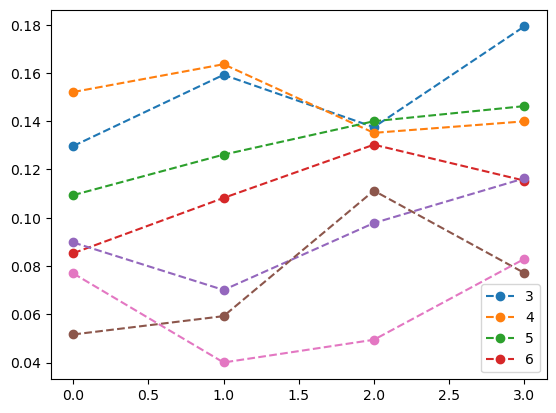

In [41]:
paths = instability.instability_path(data=X_pca, B=10)

In [42]:
paths

array([[0.12973333, 0.15210667, 0.10938667, 0.08532444, 0.08976   ,
        0.05164444, 0.07692444],
       [0.15922667, 0.16361778, 0.12616   , 0.10821333, 0.07008   ,
        0.05923556, 0.04003556],
       [0.13753778, 0.13518222, 0.14      , 0.13028444, 0.09781333,
        0.11121778, 0.04944889],
       [0.17926222, 0.13994667, 0.14625778, 0.11541333, 0.11631111,
        0.07715556, 0.08290667]])

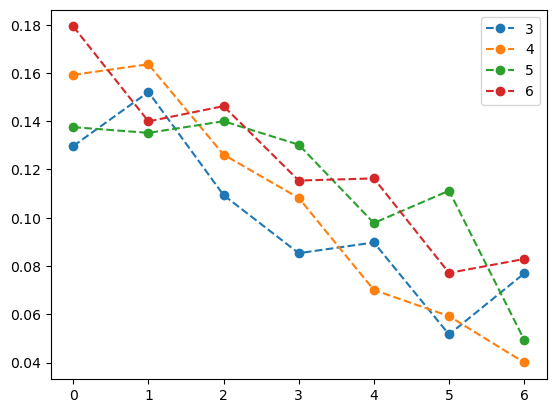

In [46]:
plt.plot(paths.T, 'o--')
plt.legend([3,4,5,6])